### 1 Import relevant libraries and define relevant paths

In [1]:
# import relevant libraries

import os # for file handling
import glob # for file handling
from tqdm import tqdm # for counter

import numpy as np # for data manipulation
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for plotting

import cv2 # read and save images
from PIL import Image # read and save images

from plantcv import plantcv as pcv # for plantcv
from scipy.ndimage import binary_dilation # for better visualization of branching points

from scipy.stats import ttest_ind # for t-test
import scipy.stats as stats # for ensuring normality of variables

C:\Users\yileh\AppData\Local\Temp\ipykernel_27360\3685281021.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # for data manipulation


In [2]:
# define dataset path
# dataset_path = '/content/drive/MyDrive/CBS/master_thesis/dataset'
dataset_path = 'c:/Users/yileh/OneDrive/msc_data_science/master_thesis/stages_images/'

### 2 Define quantification functions

Inspect one random mask

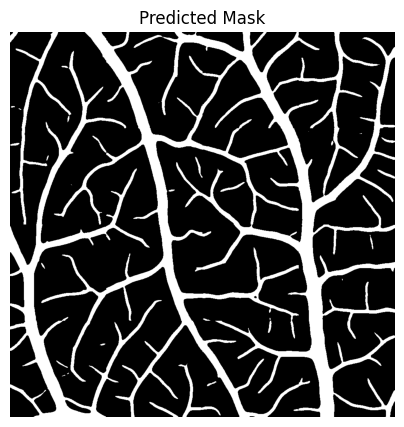

In [3]:
# choose a random mask
masks_files = glob.glob(os.path.join(dataset_path, 'd13_masks', '*.jpg'))
masks_files.sort()

# open mask
mask = np.array(Image.open(masks_files[0]).convert('1')) # binary mask
# white pixels 255, black pixels 0
mask = mask.astype(np.uint8)*255

# plot mask
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
plt.imshow(mask, cmap='gray')
plt.title('Predicted Mask')
axes.set_axis_off()

#### 2.1 Total vessel area

In [4]:
def total_vessel_area(mask):
    '''
    Calculates the total vessel area based on a binary mask (numpy.ndarray).

    Args:
      mask (numpy.ndarray): Binary mask of vessels, where vessel pixels are white (255) and background pixels are black (0).

    Returns:
      area (int): Total vessel area in pixel^2.
    '''

    # sum all pixels that are white
    area = int(np.sum(mask == 255))

    return area

In [5]:
print(f'The total vessel area is {total_vessel_area(mask=mask)} pixel^2.')

The total vessel area is 212100 pixel^2.


#### 2.2 Total vessel length

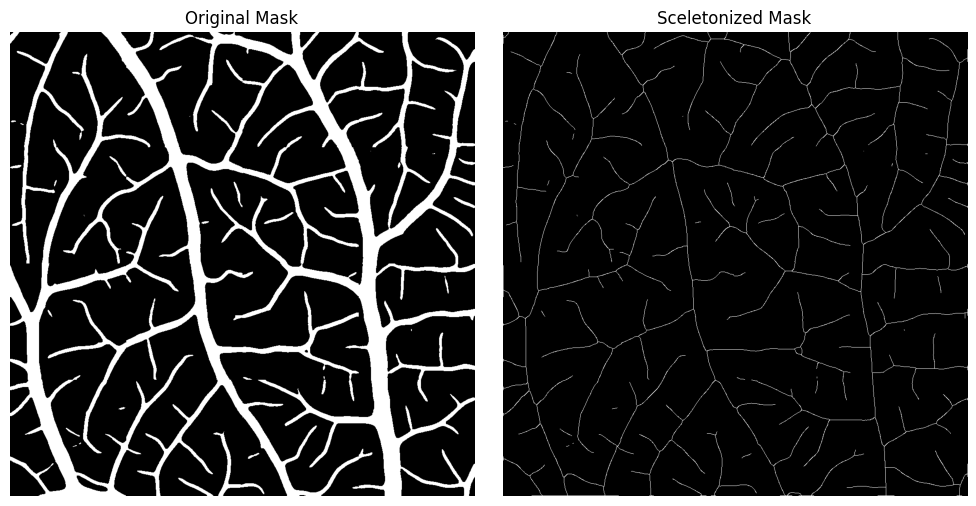

In [6]:
# skeletonize mask
skeletonized_mask = cv2.ximgproc.thinning(mask)

# create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# plot mask
axes[0].imshow(mask, cmap='gray')
axes[0].set_title('Original Mask')
axes[0].set_axis_off()

# plot skeletonized mask
axes[1].imshow(skeletonized_mask, cmap='gray')
axes[1].set_title('Sceletonized Mask')
axes[1].set_axis_off()

# adjust spacing between subplots
plt.tight_layout()

# show the masks
plt.show()

In [7]:
def total_vessel_length(mask):
    '''
    Calculates the total vessel length based on a binary mask (numpy.ndarray).

    Args:
      mask (numpy.ndarray): Binary mask of vessels, where vessel pixels are white (255) and background pixels are black (0).

    Returns:
      length (int): Total vessel length in pixel.
    '''

    # skeletonize mask
    skeletonized_mask = cv2.ximgproc.thinning(mask)

    # sum all pixels that are white
    length = int(np.sum(skeletonized_mask == 255))

    return length

In [8]:
print(f'The total vessel length is {total_vessel_length(mask=mask)} pixel.')

The total vessel length is 19560 pixel.


#### 2.3 Mean vessel thickness

In [9]:
def mean_vessel_thickness(mask):
    '''
    Calculates the mean vessel thickness based on a binary mask (numpy.ndarray).
    Based on the original mask, Euclidean Distance Transform (EDT) is used to measure the distance from each vessel pixel to the nearest background pixel.
    Skeletonized mask is employed to consider only the centerline of the vessels, excluding, for example, pixels that may be located at the vessel borders.

    Args:
      mask (numpy.ndarray): Binary mask of vessels, where vessel pixels are white (255) and background pixels are black (0).

    Returns:
      thickness (float): Mean vessel thickness in pixel.
    '''

    # skeletonize mask
    skeletonized_mask = cv2.ximgproc.thinning(mask)

    # compute Euclidean Distance Transform (EDT) on original mask
    edt = cv2.distanceTransform(mask, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)

    # for each pixel of the skeletonized mask take the EDT to background pixel (from original mask)
    vessel_thickness = 2 * edt[skeletonized_mask != 0]

    # sum up thickness values for all pixels of skeletonized mask
    total_vessel_thickness = np.sum(vessel_thickness)

    # count number of pixels of skeletonized mask
    num_skeleton_pixels = np.count_nonzero(skeletonized_mask)

    # calculate mean vessel thickness
    thickness = total_vessel_thickness / num_skeleton_pixels

    return float(round(thickness, 4))

In [10]:
print(f'The mean vessel thickness is {mean_vessel_thickness(mask=mask)} pixel.')

The mean vessel thickness is 12.3492 pixel.


#### 2.4 Number of vessel branching points

In [11]:
# skeletonize mask
skeletonized_mask = cv2.ximgproc.thinning(mask)

# find branching points
branching_points = pcv.morphology.find_branch_pts(skel_img=skeletonized_mask, mask=mask)

In [12]:
branching_points.sum()/255

126.0

In [13]:
def number_branching_points(mask):
    '''
    Calculates the number of vessel branching points based on a binary mask (numpy.ndarray).

    Args:
      mask (numpy.ndarray): Binary mask of vessels, where vessel pixels are white (255) and background pixels are black (0).

    Returns:
      branching (integer): Number of vessel branching points.
    '''

    # skeletonize mask
    skeletonized_mask = cv2.ximgproc.thinning(mask)
    
    # find branching points
    branching_points = pcv.morphology.find_branch_pts(skel_img=skeletonized_mask, mask=mask)

    # count number of branching points
    branching = int(branching_points.sum()/255)

    return branching

In [14]:
print(f'The number of vessel branching points is {number_branching_points(mask=mask)}.')

The number of vessel branching points is 126.


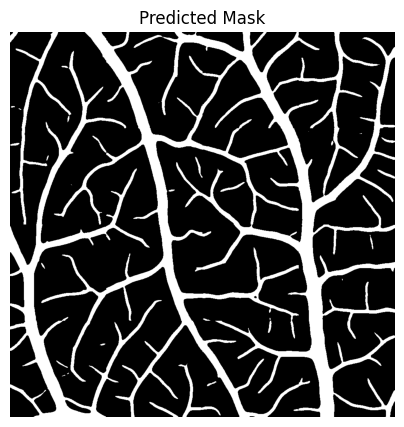

In [15]:
# choose a random mask
masks_files = glob.glob(os.path.join(dataset_path, 'd13_masks', '*.jpg'))
masks_files.sort()

# open mask
mask = np.array(Image.open(masks_files[0]).convert('1')) # binary mask
# white pixels 255, black pixels 0
mask = mask.astype(np.uint8)*255

# plot mask
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
plt.imshow(mask, cmap='gray')
plt.title('Predicted Mask')
axes.set_axis_off()

In [16]:
number_branching_points(mask=mask)

126

##### 2.4.1 Visualize mask, skeleton, and branching points

In [17]:
# create empty image
image = np.zeros((1024, 1024, 3), dtype=np.uint8)

# find all vessel pixels of mask
vessel_pixels = np.where(mask == 255)

# add white color to vessel pixels
for i in range(len(vessel_pixels[0])):
    image[vessel_pixels[0][i], vessel_pixels[1][i]] = [150, 150, 150]

# create skeleton
skeleton = cv2.ximgproc.thinning(mask)
# apply dilation to make vessels thicker
dilated_skeleton_mask = binary_dilation(skeleton, structure=np.ones((2,2)))

# find all skeleton pixels
skeleton_pixels = np.where(dilated_skeleton_mask == 1)

# add red color to skeleton pixels
for i in range(len(skeleton_pixels[0])):
    image[skeleton_pixels[0][i], skeleton_pixels[1][i]] = [255, 0, 0]
    
# create branching points
branching_points = pcv.morphology.find_branch_pts(skel_img=skeleton, mask=mask)

# apply kernel to make branching points more visible
kernel = np.ones((10,10),np.uint8)
# branching_points = cv2.dilate(branching_points.astype(np.uint8), kernel, iterations=1)
branching_points_thickened = binary_dilation(branching_points, structure=kernel)

# find all branching points
branching_points_visualized = np.where(branching_points_thickened == 1)

# add yellow color to branching points 
for i in range(len(branching_points_visualized[0])):
    image[branching_points_visualized[0][i], branching_points_visualized[1][i]] = [0, 255, 0]

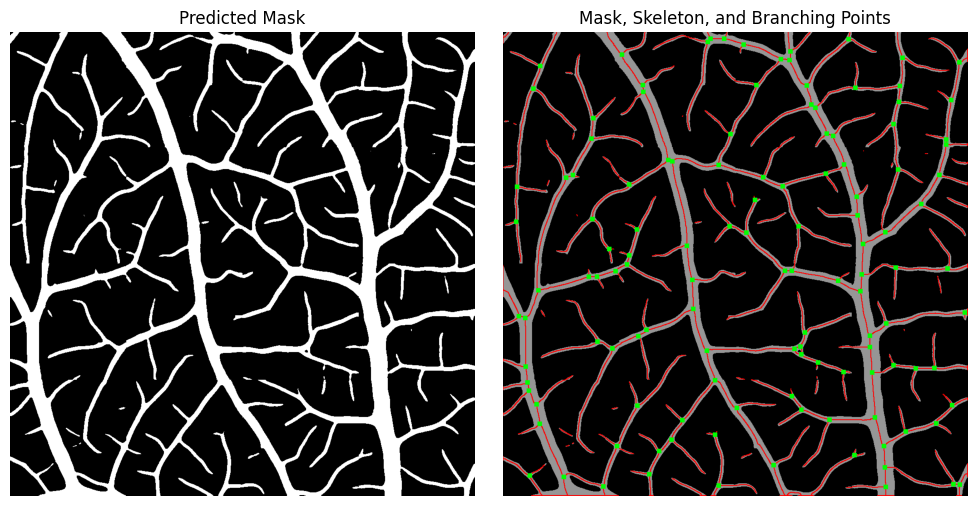

In [18]:
# create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# plot mask
axes[0].imshow(mask, cmap='gray')
axes[0].set_title('Predicted Mask')
axes[0].set_axis_off()

# plot mask with branching points
axes[1].imshow(image, cmap='gray')
axes[1].set_title('Mask, Skeleton, and Branching Points')
axes[1].set_axis_off()

# adjust spacing between subplots
plt.tight_layout()

# show the masks
plt.show()

### 3 Calculate the results for all masks

In [19]:
# create a function to go through all masks and calculate the metrics
def calculate_metrics(dataset_path, stage, target_path=None):
    '''
    Calculates the metrics for all masks in the dataset.

    Args:
      dataset_path (str): Path to the masks.
      stage (str): Stage of the vessels, e.g., d9.
      target_path (str, optional): Path to save images with visualized metrics (default is None).

    Returns:
      df (pandas.DataFrame): Dataframe with the results.
    '''

    # create an empty dataframe to store the results
    df = pd.DataFrame(columns=['stage', 'image_id', 'total_vessel_area', 'total_vessel_length', 'mean_vessel_thickness', 'number_of_vessel_branching_points'])
    
    # get all mask files
    masks_files = glob.glob(os.path.join(dataset_path, '*.jpg'))
    masks_files.sort()

    # go through all masks
    for mask_file in tqdm(masks_files):

        # open mask
        mask = np.array(Image.open(mask_file).convert('1')) # binary mask
        # white pixels 255, black pixels 0
        mask = mask.astype(np.uint8)*255

        # calculate metrics
        total_area = total_vessel_area(mask=mask)
        total_length = total_vessel_length(mask=mask)
        mean_thickness = mean_vessel_thickness(mask=mask)
        number_branching = number_branching_points(mask=mask)

        # get image id
        image_id = os.path.basename(mask_file).split('.')[0]

        # define new row
        new_row = {'stage': stage, 
                    'image_id': image_id, 
                    'total_vessel_area': float(total_area), 
                    'total_vessel_length': float(total_length), 
                    'mean_vessel_thickness': float(mean_thickness), 
                    'number_of_vessel_branching_points': float(number_branching)}
        
        # append results to dataframe
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

        if target_path:
            # create empty image
            image = np.zeros((1024, 1024, 3), dtype=np.uint8)

            # find all vessel pixels of mask
            vessel_pixels = np.where(mask == 255)

            # add white color to vessel pixels
            for i in range(len(vessel_pixels[0])):
                image[vessel_pixels[0][i], vessel_pixels[1][i]] = [150, 150, 150]

            # create skeleton
            skeleton = cv2.ximgproc.thinning(mask)
            # apply dilation to make vessels thicker
            dilated_skeleton_mask = binary_dilation(skeleton, structure=np.ones((2,2)))

            # find all skeleton pixels
            skeleton_pixels = np.where(dilated_skeleton_mask == 1)

            # add red color to skeleton pixels
            for i in range(len(skeleton_pixels[0])):
                image[skeleton_pixels[0][i], skeleton_pixels[1][i]] = [255, 0, 0]
                
            # create branching points
            branching_points = pcv.morphology.find_branch_pts(skel_img=skeleton, mask=None)

            # apply kernel to make branching points more visible
            kernel = np.ones((10,10),np.uint8)
            # branching_points = cv2.dilate(branching_points.astype(np.uint8), kernel, iterations=1)
            branching_points_thickened = binary_dilation(branching_points, structure=kernel)

            # find all branching points
            branching_points_visualized = np.where(branching_points_thickened == 1)

            # add green color to branching points 
            for i in range(len(branching_points_visualized[0])):
                image[branching_points_visualized[0][i], branching_points_visualized[1][i]] = [0, 255, 0]

            # save image with visualized metrics
            Image.fromarray(image).save(os.path.join(target_path, f'{image_id}.jpg'))
    
    return df

#### 3.1 Calculate results for day 11 and check entries

In [20]:
d11_df = calculate_metrics(dataset_path=os.path.join(dataset_path, 'd11_masks'), stage='d11', target_path=os.path.join(dataset_path, 'd11_masks_quant'))

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\yileh\AppData\Local\Temp\ipykernel_27360\3126736648.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
100%|██████████| 25/25 [00:46<00:00,  1.86s/it]


In [21]:
# check first rows of the dataframe
d11_df.head()

,stage,image_id,total_vessel_area,total_vessel_length,mean_vessel_thickness,number_of_vessel_branching_points
0,d11,001,136611.0,13097.0,11.4117,67.0
1,d11,002,151405.0,11728.0,14.3534,57.0
2,d11,003,158203.0,15085.0,11.8678,77.0
3,d11,004,116540.0,11634.0,10.7978,59.0
4,d11,005,149595.0,13434.0,12.6796,75.0


In [22]:
# provide summary of results
d11_df.describe()

,total_vessel_area,total_vessel_length,mean_vessel_thickness,number_of_vessel_branching_points
count,25.000000,25.000000,25.000000,25.000000
mean,137487.320000,12592.000000,12.038840,60.360000
std,19832.155524,1404.457102,1.570982,13.319409
min,99488.000000,9881.000000,9.586200,23.000000
25%,125469.000000,11728.000000,10.797800,54.000000
50%,135512.000000,12797.000000,11.729200,62.000000
75%,150146.000000,13434.000000,12.952400,68.000000
max,190034.000000,15085.000000,15.491900,89.000000


#### 3.2 Calculate results for day 13 and check entries

In [23]:
d13_df = calculate_metrics(dataset_path=os.path.join(dataset_path, 'd13_masks'), stage='d13', target_path=os.path.join(dataset_path, 'd13_masks_quant'))

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\yileh\AppData\Local\Temp\ipykernel_27360\3126736648.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


In [24]:
# check first rows of the dataframe
d13_df.head()

,stage,image_id,total_vessel_area,total_vessel_length,mean_vessel_thickness,number_of_vessel_branching_points
0,d13,001,212100.0,19560.0,12.3492,126.0
1,d13,002,234282.0,20245.0,12.9058,130.0
2,d13,003,234318.0,20031.0,13.8546,133.0
3,d13,004,198673.0,17319.0,12.6538,80.0
4,d13,005,181609.0,17565.0,11.3493,116.0


In [25]:
# provide summary of results
d13_df.describe()

,total_vessel_area,total_vessel_length,mean_vessel_thickness,number_of_vessel_branching_points
count,25.000000,25.000000,25.000000,25.000000
mean,208824.480000,18256.920000,13.065232,116.800000
std,30650.264414,2104.087211,1.163573,26.741042
min,137266.000000,12346.000000,11.093600,46.000000
25%,194237.000000,16816.000000,12.349200,102.000000
50%,207287.000000,18562.000000,13.082800,122.000000
75%,218748.000000,19647.000000,13.854600,136.000000
max,292272.000000,22615.000000,15.567300,167.000000


#### 3.3 Create and store dataframe with results

In [26]:
# concatenate dataframes
df = pd.concat([d11_df, d13_df], ignore_index=True)

# save dataframe
df.to_csv(os.path.join(dataset_path, 'vessel_metrics.csv'), index=False)

### 4 Statistical analysis

Each variable is visualized using boxplots. After, each variable is checked visually and with the Shapiro-Wilk test for normality. A t-test is conducted to confirm a significant difference between both stages for each variable.

In [27]:
# load dataframe
df = pd.read_csv(os.path.join(dataset_path, 'vessel_metrics.csv'))

#### 4.1 Total vessel area

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\yileh\AppData\Local\Temp\ipykernel_27360\1150052190.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Total Vessel Area ($\mathrm{pixels}^2$)')


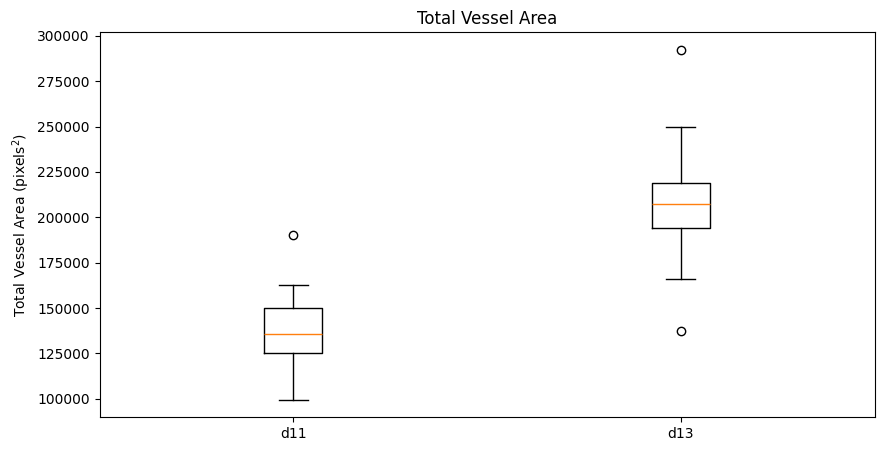

In [28]:
# create boxplot for each stage
plt.figure(figsize=(10, 5))
plt.title('Total Vessel Area')
plt.boxplot([df[df['stage'] == 'd11']['total_vessel_area'], df[df['stage'] == 'd13']['total_vessel_area']], labels=['d11', 'd13'])
plt.ylabel('Total Vessel Area ($\mathrm{pixels}^2$)')
plt.show()

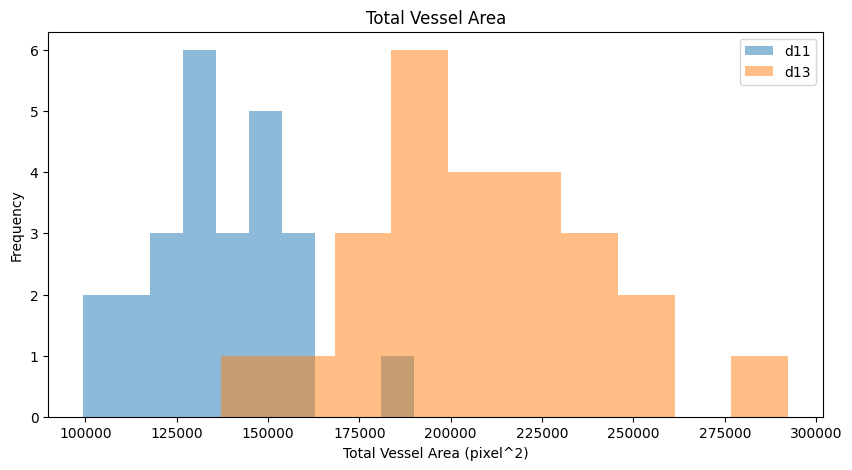

In [29]:
# plot histogram for both stages to examine the distribution
plt.figure(figsize=(10, 5))
plt.title('Total Vessel Area')
plt.xlabel('Total Vessel Area (pixel^2)')
plt.ylabel('Frequency')
plt.hist(df[df['stage'] == 'd11']['total_vessel_area'], alpha=0.5, label='d11')
plt.hist(df[df['stage'] == 'd13']['total_vessel_area'], alpha=0.5, label='d13')
plt.legend()
plt.show()

In [30]:
# check that both stages are normally distributed
# shapiro-Wilk test
# null-hypothesis: data is normally distributed
shapiro_test_d11 = stats.shapiro(df[df['stage'] == 'd11']['total_vessel_length'])
print('Shapiro-Wilk p-value:', shapiro_test_d11.pvalue)
if shapiro_test_d11.pvalue > 0.05:
    print('Data is normally distributed for d11.')

shapiro_test_d13 = stats.shapiro(df[df['stage'] == 'd13']['total_vessel_length'])
print('\nShapiro-Wilk p-value:', shapiro_test_d13.pvalue)
if shapiro_test_d13.pvalue > 0.05:
    print('Data is normally distributed for d13.')

Shapiro-Wilk p-value: 0.7284726410439701
Data is normally distributed for d11.

Shapiro-Wilk p-value: 0.20758891166266402
Data is normally distributed for d13.


In [31]:
# calculate t-test
print(ttest_ind(df[df['stage'] == 'd11']['total_vessel_area'], df[df['stage'] == 'd13']['total_vessel_area']))

# check if the difference is significant
if ttest_ind(df[df['stage'] == 'd11']['total_vessel_area'], df[df['stage'] == 'd13']['total_vessel_area']).pvalue < 0.05:
    print('The difference in total vessel area between d11 and d13 is significant.')

TtestResult(statistic=-9.770369066461361, pvalue=5.388734116669092e-13, df=48.0)
The difference in total vessel area between d11 and d13 is significant.


#### 4.2 Total vessel length

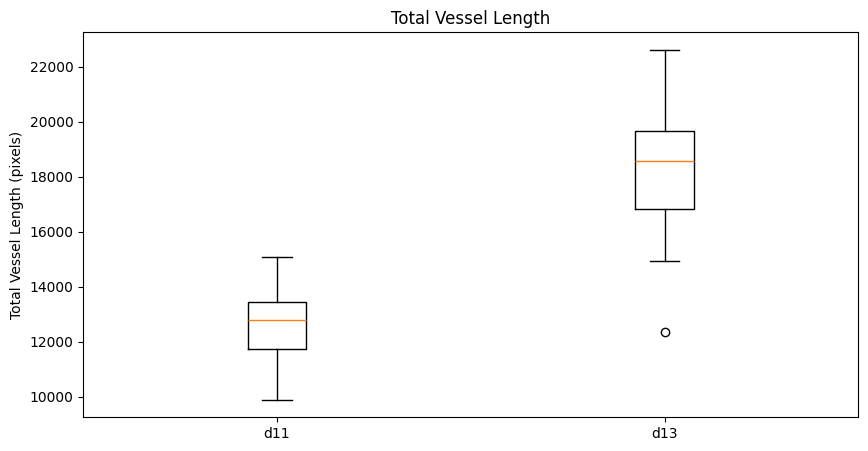

In [32]:
# create boxplot for each stage
plt.figure(figsize=(10, 5))
plt.title('Total Vessel Length')
plt.boxplot([df[df['stage'] == 'd11']['total_vessel_length'], df[df['stage'] == 'd13']['total_vessel_length']], labels=['d11', 'd13'])
plt.ylabel('Total Vessel Length (pixels)')
plt.show()

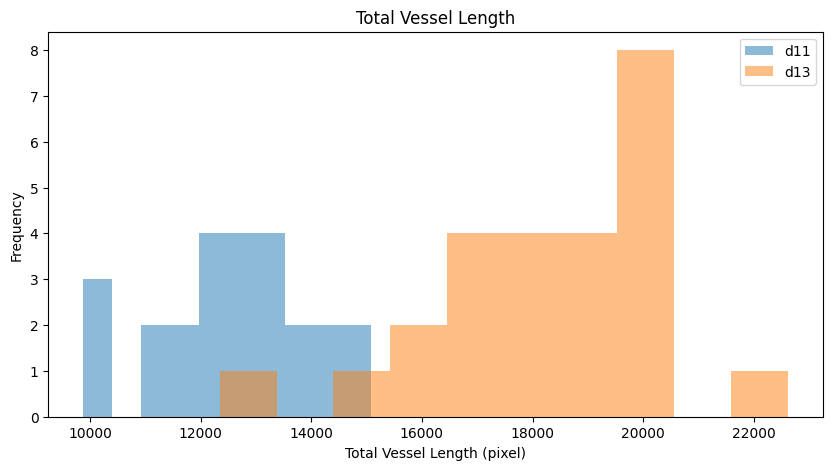

In [33]:
# plot histogram for both stages to examine the distribution
plt.figure(figsize=(10, 5))
plt.title('Total Vessel Length')
plt.xlabel('Total Vessel Length (pixel)')
plt.ylabel('Frequency')
plt.hist(df[df['stage'] == 'd11']['total_vessel_length'], alpha=0.5, label='d11')
plt.hist(df[df['stage'] == 'd13']['total_vessel_length'], alpha=0.5, label='d13')
plt.legend()
plt.show()

In [34]:
# check that both stages are normally distributed
# shapiro-Wilk test
# null-hypothesis: data is normally distributed
shapiro_test_d11 = stats.shapiro(df[df['stage'] == 'd11']['total_vessel_length'])
print('Shapiro-Wilk p-value:', shapiro_test_d11.pvalue)
if shapiro_test_d11.pvalue > 0.05:
    print('Data is normally distributed for d11.')

shapiro_test_d13 = stats.shapiro(df[df['stage'] == 'd13']['total_vessel_length'])
print('\nShapiro-Wilk p-value:', shapiro_test_d13.pvalue)
if shapiro_test_d13.pvalue > 0.05:
    print('Data is normally distributed for d13.')

Shapiro-Wilk p-value: 0.7284726410439701
Data is normally distributed for d11.

Shapiro-Wilk p-value: 0.20758891166266402
Data is normally distributed for d13.


In [35]:
# calculate t-test
print(ttest_ind(df[df['stage'] == 'd11']['total_vessel_length'], df[df['stage'] == 'd13']['total_vessel_length']))

# check if the difference is significant
if ttest_ind(df[df['stage'] == 'd11']['total_vessel_length'], df[df['stage'] == 'd13']['total_vessel_length']).pvalue < 0.05:
    print('The difference in total vessel length between d11 and d13 is significant.')

TtestResult(statistic=-11.196558744379413, pvalue=5.508385383740826e-15, df=48.0)
The difference in total vessel length between d11 and d13 is significant.


#### 4.3 Mean vessel thickness

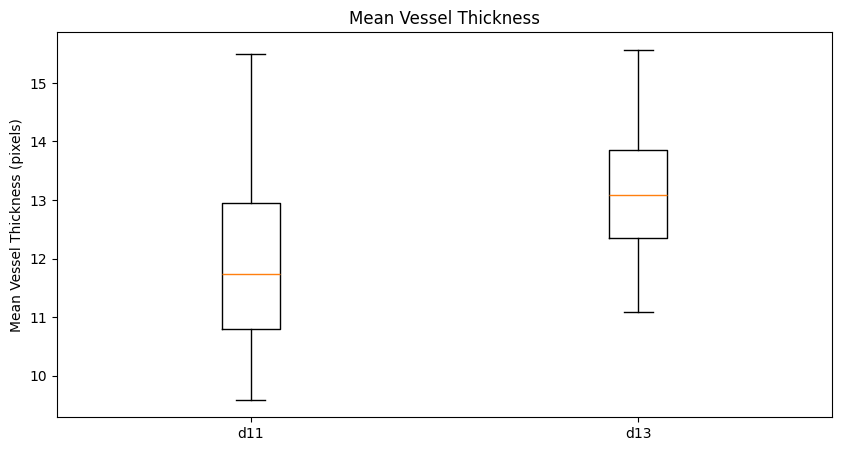

In [36]:
# create boxplot for each stage
plt.figure(figsize=(10, 5))
plt.title('Mean Vessel Thickness')
plt.boxplot([df[df['stage'] == 'd11']['mean_vessel_thickness'], df[df['stage'] == 'd13']['mean_vessel_thickness']], labels=['d11', 'd13'])
plt.ylabel('Mean Vessel Thickness (pixels)')
plt.show()

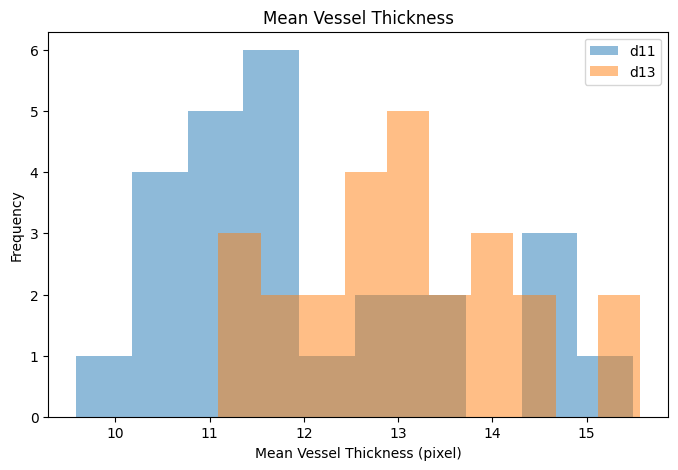

In [37]:
# plot histogram for both stages to examine the distribution
plt.figure(figsize=(8, 5))
plt.title('Mean Vessel Thickness')
plt.xlabel('Mean Vessel Thickness (pixel)')
plt.ylabel('Frequency')
plt.hist(df[df['stage'] == 'd11']['mean_vessel_thickness'], alpha=0.5, label='d11')
plt.hist(df[df['stage'] == 'd13']['mean_vessel_thickness'], alpha=0.5, label='d13')
plt.legend()
plt.show()

In [38]:
# check that both stages are normally distributed
# shapiro-Wilk test
# null-hypothesis: data is normally distributed
shapiro_test_d11 = stats.shapiro(df[df['stage'] == 'd11']['mean_vessel_thickness'])
print('Shapiro-Wilk p-value:', shapiro_test_d11.pvalue)
if shapiro_test_d11.pvalue > 0.05:
    print('Data is normally distributed for d11.')
    
shapiro_test_d13 = stats.shapiro(df[df['stage'] == 'd13']['mean_vessel_thickness'])
print('\nShapiro-Wilk p-value:', shapiro_test_d13.pvalue)
if shapiro_test_d13.pvalue > 0.05:
    print('Data is normally distributed for d13.')

Shapiro-Wilk p-value: 0.12165799461319099
Data is normally distributed for d11.

Shapiro-Wilk p-value: 0.8797509502966938
Data is normally distributed for d13.


In [39]:
# calculate t-test
print(ttest_ind(df[df['stage'] == 'd11']['mean_vessel_thickness'], df[df['stage'] == 'd13']['mean_vessel_thickness']))

# check if the difference is significant
if ttest_ind(df[df['stage'] == 'd11']['mean_vessel_thickness'], df[df['stage'] == 'd13']['mean_vessel_thickness']).pvalue < 0.05:
    print('\nThe difference in mean vessel thickness between d9 and d13 is significant.')

TtestResult(statistic=-2.6250916815597276, pvalue=0.011585368964771109, df=48.0)

The difference in mean vessel thickness between d9 and d13 is significant.


#### 4.4 Number of vessel branching points

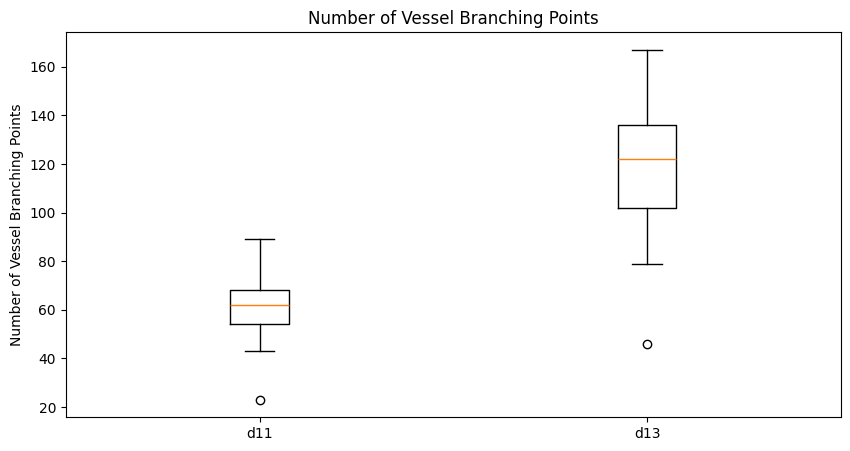

In [40]:
# create boxplot for each stage
plt.figure(figsize=(10, 5))
plt.title('Number of Vessel Branching Points')
plt.boxplot([df[df['stage'] == 'd11']['number_of_vessel_branching_points'], df[df['stage'] == 'd13']['number_of_vessel_branching_points']], labels=['d11', 'd13'])
plt.ylabel('Number of Vessel Branching Points')
plt.show()

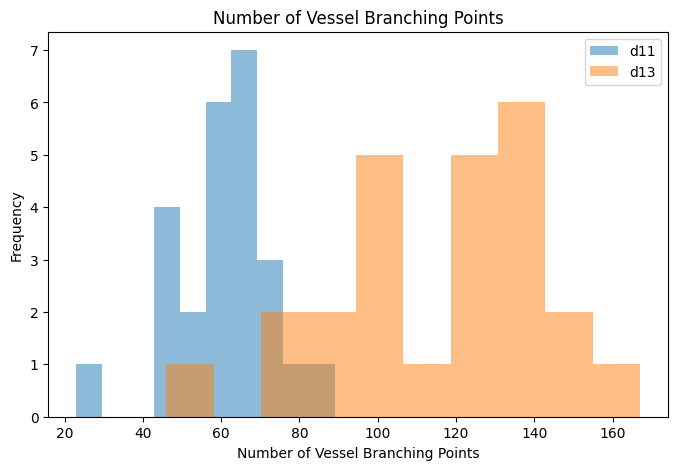

In [41]:
# plot histogram for both stages to examine the distribution
plt.figure(figsize=(8, 5))
plt.title('Number of Vessel Branching Points')
plt.xlabel('Number of Vessel Branching Points')
plt.ylabel('Frequency')
plt.hist(df[df['stage'] == 'd11']['number_of_vessel_branching_points'], alpha=0.5, label='d11')
plt.hist(df[df['stage'] == 'd13']['number_of_vessel_branching_points'], alpha=0.5, label='d13')
plt.legend()    
plt.show()

In [42]:
# check that both stages are normally distributed
# shapiro-Wilk test
# null-hypothesis: data is normally distributed
shapiro_test_d11 = stats.shapiro(df[df['stage'] == 'd11']['number_of_vessel_branching_points'])
print('Shapiro-Wilk p-value:', shapiro_test_d11.pvalue)
if shapiro_test_d11.pvalue > 0.05:
    print('Data is normally distributed for d11.')
    
shapiro_test_d13 = stats.shapiro(df[df['stage'] == 'd13']['number_of_vessel_branching_points'])
print('\nShapiro-Wilk p-value:', shapiro_test_d13.pvalue)
if shapiro_test_d13.pvalue > 0.05:
    print('Data is normally distributed for d13.')

Shapiro-Wilk p-value: 0.5128239288282288
Data is normally distributed for d11.

Shapiro-Wilk p-value: 0.39946371963971194
Data is normally distributed for d13.


In [43]:
# calculate t-test
print(ttest_ind(df[df['stage'] == 'd11']['number_of_vessel_branching_points'], df[df['stage'] == 'd13']['number_of_vessel_branching_points']))

# check if the difference is significant
if ttest_ind(df[df['stage'] == 'd11']['number_of_vessel_branching_points'], df[df['stage'] == 'd13']['number_of_vessel_branching_points']).pvalue < 0.05:
    print('The difference in number of vessel branching points between d9 and d13 is significant.')

TtestResult(statistic=-9.446160709850679, pvalue=1.5811917475018223e-12, df=48.0)
The difference in number of vessel branching points between d9 and d13 is significant.
